![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

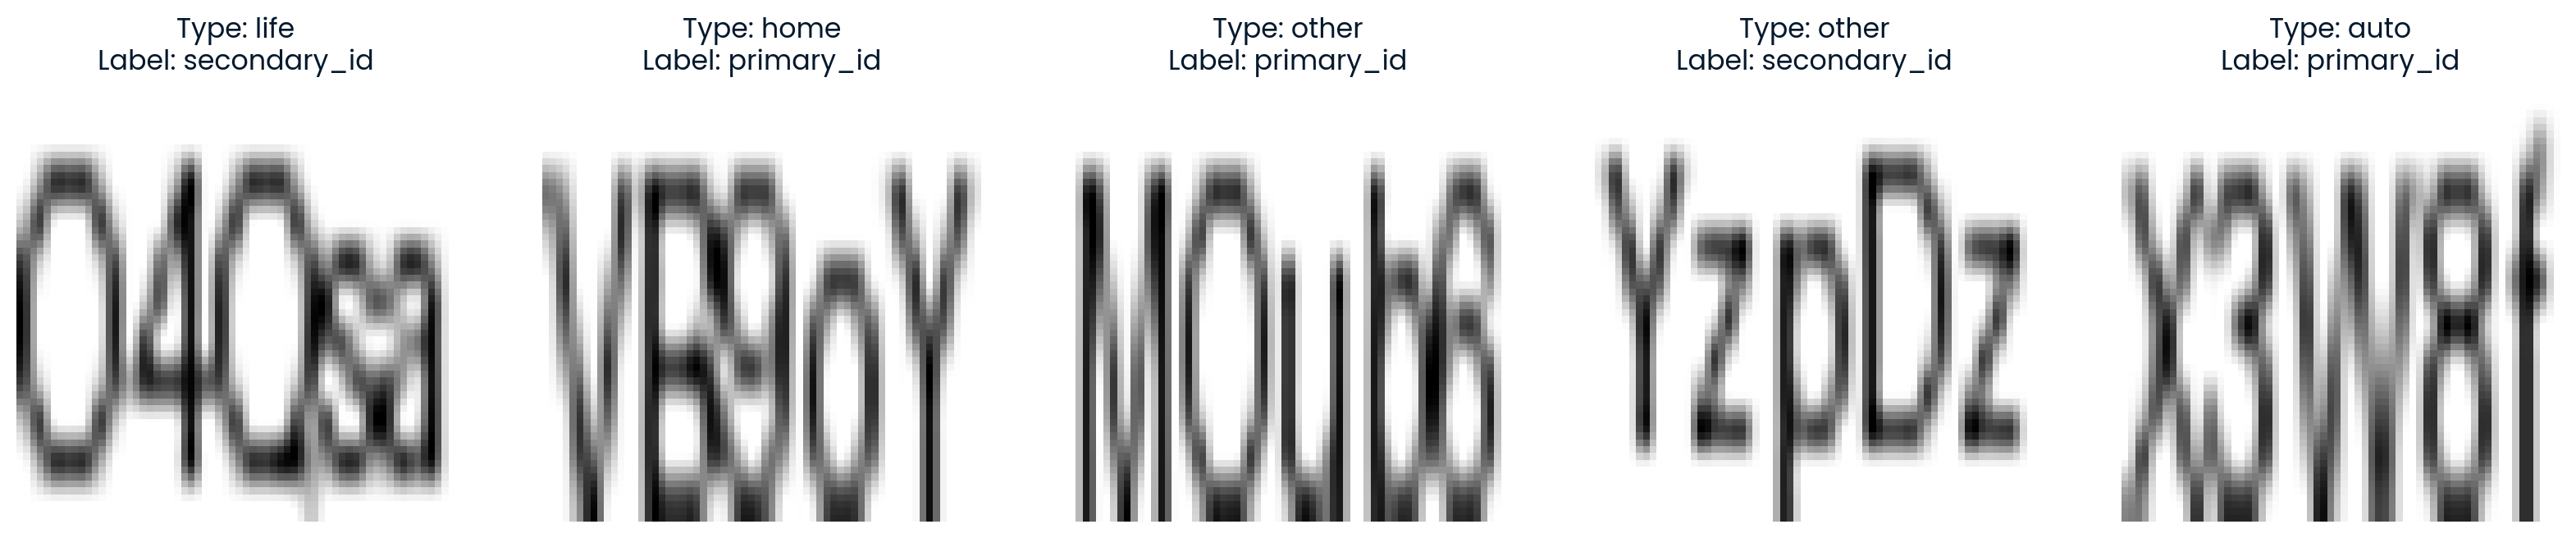

In [4]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [5]:
# Start coding here
# --- 1. Set up the DataLoader ---
# We'll use the entire dataset for training as requested by the prompt.
# In a real-world scenario, you would split this into train/validation sets.
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- 2. Define the OCRModel Class ---

# Get dimensions from the dataset for model inputs/outputs
num_types = len(dataset.type_mapping)
num_classes = len(dataset.label_mapping)

class OCRModel(nn.Module):
    def __init__(self, num_types, num_classes):
        super(OCRModel, self).__init__()
        
        # --- Image Processing Layers ---
        # This sequential module processes the 1x64x64 image as required
        self.image_layer = nn.Sequential(
            # The required Conv2d layer (Input: 1x64x64 -> Output: 16x64x64)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (Output: 16x32x32)
            
            # Add more layers to extract deeper features
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (Output: 32x16x16)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (Output: 64x8x8)
            
            # Flatten the 3D feature map into a 1D vector
            nn.Flatten() # (Output: 64 * 8 * 8 = 4096)
        )
        
        # --- Type Processing Layer ---
        # A simple linear layer to process the one-hot encoded document type
        # It creates an embedding for the document type
        self.type_layer = nn.Linear(num_types, 32)
        
        # --- Classifier (Combiner) ---
        # This combines the features from the image and the type
        self.classifier = nn.Sequential(
            # Input size = 4096 (from image) + 32 (from type)
            nn.Linear(4096 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout for regularization
            nn.Linear(128, num_classes) # Final output layer for classes
        )
        
    def forward(self, x_image, x_type):
        # 1. Process the image through its layers
        image_features = self.image_layer(x_image)
        
        # 2. Process the type through its layer (with ReLU activation)
        type_features = torch.relu(self.type_layer(x_type))
        
        # 3. Concatenate the features from both inputs
        combined_features = torch.cat((image_features, type_features), dim=1)
        
        # 4. Pass the combined features through the final classifier
        logits = self.classifier(combined_features)
        return logits

# --- 3. Initialize Model, Loss, and Optimizer ---

# Set device (use GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available(): # For Apple Silicon
    device = "mps"
else:
    device = "cpu"
    
print(f"Using device: {device}")

# Create an instance of the model and move it to the device
model = OCRModel(num_types=num_types, num_classes=num_classes).to(device)

# Define an appropriate loss function: CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define an appropriate optimizer: Adam is a robust choice
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 4. Train the Model ---

num_epochs = 10
model.train() # Set the model to training mode

print("Starting training...")

for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Loop over the data loader
    for data, labels in train_loader:
        # data is a list: [images, types]
        images, types = data
        
        # Move all tensors to the selected device
        images = images.to(device)
        types = types.to(device)
        labels = labels.to(device)
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(images, types)
        
        # 3. Calculate the loss
        loss = criterion(outputs, labels)
        
        # 4. Backward pass
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
        
    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Finished Training.")

Using device: cpu
Starting training...
Epoch [1/10], Loss: 0.7063
Epoch [2/10], Loss: 0.6971
Epoch [3/10], Loss: 0.6826
Epoch [4/10], Loss: 0.6808
Epoch [5/10], Loss: 0.6870
Epoch [6/10], Loss: 0.7230
Epoch [7/10], Loss: 0.6912
Epoch [8/10], Loss: 0.7012
Epoch [9/10], Loss: 0.6929
Epoch [10/10], Loss: 0.6863
Finished Training.
